In this project, the churn rate will be investigated for an online food order platform. The customers in the dataset have already given order from the platform once, it will be predicted whether they will order again.  

In [1]:
import numpy as np 
import pandas as pd 

/kaggle/input/foodorders/onlinefoods.csv


In [2]:
from random import choice
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set_theme(style = "whitegrid")
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
import warnings
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV, cross_validate
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score

warnings.simplefilter(action='ignore', category=Warning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)


Below the functions are defined for future use.

In [3]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

def grab_col_names(dataframe, cat_th=10, car_th=20):

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(numerical_col).agg({target: "mean"}), end="\n\n\n")

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")


def quick_missing_imp(data, num_method="median", cat_length=20, target="SalePrice"):
    variables_with_na = [col for col in data.columns if
                         data[col].isnull().sum() > 0]  # Eksik değere sahip olan değişkenler listelenir

    temp_target = data[target]

    print("# BEFORE")
    print(data[variables_with_na].isnull().sum(), "\n\n")  

   
    data = data.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= cat_length) else x,
                      axis=0)


    if num_method == "mean":
        data = data.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)
  
    elif num_method == "median":
        data = data.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)

    data[target] = temp_target

    print("# AFTER \n Imputation method is 'MODE' for categorical variables!")
    print(" Imputation method is '" + num_method.upper() + "' for numeric variables! \n")
    print(data[variables_with_na].isnull().sum(), "\n\n")

    return data


def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

def rare_encoder(dataframe, rare_perc, cat_cols):
    rare_columns = [col for col in cat_cols if (dataframe[col].value_counts() / len(dataframe) < 0.01).sum() > 1]

    for col in rare_columns:
        tmp = dataframe[col].value_counts() / len(dataframe)
        rare_labels = tmp[tmp < rare_perc].index
        dataframe[col] = np.where(dataframe[col].isin(rare_labels), 'Rare', dataframe[col])




def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe



### Extending the Dataframe

The dataset is pretty small, therefore it will be extended from the values in itself.

In [4]:
choice_list = []

In [5]:
dforiginal= pd.read_csv("../input/foodorders/onlinefoods.csv")

In [6]:
dforiginal.head()

,Age,Gender,Marital Status,Occupation,Monthly Income,Educational Qualifications,Family size,latitude,longitude,Pin code,Output,Feedback,Unnamed: 12
0,20,Female,Single,Student,No Income,Post Graduate,4,12.977,77.599,560001,Yes,Positive,Yes
1,24,Female,Single,Student,Below Rs.10000,Graduate,3,12.977,77.577,560009,Yes,Positive,Yes
2,22,Male,Single,Student,Below Rs.10000,Post Graduate,3,12.955,77.659,560017,Yes,Negative,Yes
3,22,Female,Single,Student,No Income,Graduate,6,12.947,77.562,560019,Yes,Positive,Yes
4,22,Male,Single,Student,Below Rs.10000,Post Graduate,4,12.985,77.553,560010,Yes,Positive,Yes


In [7]:
colnames = dforiginal.columns.values
print(colnames)

['Age' 'Gender' 'Marital Status' 'Occupation' 'Monthly Income'
 'Educational Qualifications' 'Family size' 'latitude' 'longitude'
 'Pin code' 'Output' 'Feedback' 'Unnamed: 12']


In [8]:
dfnew=pd.DataFrame()

In [9]:
for i in range(0,len(colnames)):
   column_name = colnames[i]
   valueslist = dforiginal[column_name].tolist()
   for _ in range(3000):
      selection = choice(valueslist)
      choice_list.append(selection)
   dfnew[column_name]= pd.DataFrame(choice_list, columns=[column_name])
   choice_list.clear()

In [10]:
df = dforiginal.append(dfnew, ignore_index=True)


In [11]:
df.drop(['Pin code', 'Unnamed: 12'], axis=1, inplace=True)

## Feature Engineering

In [12]:
check_df(df)

##################### Shape #####################
(3388, 11)
##################### Types #####################
Age                             int64
Gender                         object
Marital Status                 object
Occupation                     object
Monthly Income                 object
Educational Qualifications     object
Family size                     int64
latitude                      float64
longitude                     float64
Output                         object
Feedback                       object
dtype: object
##################### Head #####################
   Age  Gender Marital Status Occupation  Monthly Income Educational Qualifications  Family size  latitude  longitude Output   Feedback
0   20  Female         Single    Student       No Income              Post Graduate            4    12.977     77.599    Yes   Positive
1   24  Female         Single    Student  Below Rs.10000                   Graduate            3    12.977     77.577    Yes   Positive


In [13]:
df["Output"] = df.apply(lambda x: 1 if x["Output"] =="Yes" else 0, axis=1 )
df["Gender"] = df.apply(lambda x: 1 if x["Gender"] == "Male" else 0, axis =1)
df["Marital Status"] = df.apply(lambda x: 1 if x["Marital Status"] == "Married" else 0, axis =1)
df["Feedback"] = df.apply(lambda x: 1 if x["Feedback"] == "Positive" else 0, axis =1)


In [14]:
df.loc[(df["Occupation"] == "House wife") | (df["Occupation"] == "Student"), "Occupation"] = 0
df.loc[df["Occupation"] == "Self Employeed", "Occupation"] = 1
df.loc[df["Occupation"] == "Employee", "Occupation"] = 2
df.loc[df["Educational Qualifications"] == "Uneducated", "Educational Qualifications"] = 0
df.loc[df["Educational Qualifications"] == "School", "Educational Qualifications"] = 1
df.loc[df["Educational Qualifications"] == "Graduate", "Educational Qualifications"] = 2
df.loc[df["Educational Qualifications"] == "Post Graduate", "Educational Qualifications"] = 3
df.loc[df["Educational Qualifications"] == "Ph.D", "Educational Qualifications"] = 4

In [15]:
df.loc[df["Family size"] == 1, "Family size_cat"] = "Single"
df.loc[(df["Family size"] > 1) & (df["Family size"]<=3), "Family size_cat"] = "Medium"
df.loc[df["Family size"] > 3, "Family size_cat"] = "Crowded"


In [16]:
df["Monthly Income"].unique()

array(['No Income', 'Below Rs.10000', 'More than 50000', '10001 to 25000',
       '25001 to 50000'], dtype=object)

In [17]:
df.loc[df["Monthly Income"] == "No Income", "Monthly Income"] = 0
df.loc[df["Monthly Income"] == 'Below Rs.10000', "Monthly Income"] = 1
df.loc[df["Monthly Income"] == '10001 to 25000', "Monthly Income"] = 2
df.loc[df["Monthly Income"] == '25001 to 50000', "Monthly Income"] = 3
df.loc[df["Monthly Income"] == 'More than 50000', "Monthly Income"] = 4

In [18]:
df["Income per capita"] = df["Monthly Income"] / df["Family size"]

In [19]:
df["Age_income"] = df["Age"]*df["Income per capita"]
df["Age_monthlyi"] = df["Age"]*df["Monthly Income"]
df["Edu_inc"] = df["Educational Qualifications"]*df["Income per capita"]
df["Age_fam"] = df["Family size"] * df["Age"]
df["Age_occ"] = df["Age"]*df["Occupation"]
df["Edu_occ"] = df["Educational Qualifications"]*df["Occupation"]
df["Edu_occ_inc"] = df["Educational Qualifications"]*df["Occupation"]*df["Income per capita"]
df["Edu_fam"] = df["Educational Qualifications"]/df["Family size"]
df["Occ_fam"] = df["Occupation"]/df["Family size"]

In [20]:
df.loc[df["Income per capita"] <= 0.5, "Income_cat"] = 0
df.loc[(df["Income per capita"] > 0.5) & (df["Income per capita"]<1.5), "Income_cat"] = 1
df.loc[(df["Income per capita"] >= 1.5) & (df["Income per capita"] <= 2.0), "Income_cat"] = 2
df.loc[df["Income per capita"] > 2.0, "Income_cat"] = 3

In [21]:
df["Income_cat"] = df["Income_cat"].astype(int)

In [22]:
df.head()

,Age,Gender,Marital Status,Occupation,Monthly Income,Educational Qualifications,Family size,latitude,longitude,Output,Feedback,Family size_cat,Income per capita,Age_income,Age_monthlyi,Edu_inc,Age_fam,Age_occ,Edu_occ,Edu_occ_inc,Edu_fam,Occ_fam,Income_cat
0,20,0,0,0,0,3,4,12.977,77.599,1,1,Crowded,0.000,0.000,0,0.000,80,0,0,0.000,0.750,0.000,0
1,24,0,0,0,1,2,3,12.977,77.577,1,1,Medium,0.333,8.000,24,0.667,72,0,0,0.000,0.667,0.000,0
2,22,1,0,0,1,3,3,12.955,77.659,1,0,Medium,0.333,7.333,22,1.000,66,0,0,0.000,1.000,0.000,0
3,22,0,0,0,0,2,6,12.947,77.562,1,1,Crowded,0.000,0.000,0,0.000,132,0,0,0.000,0.333,0.000,0
4,22,1,0,0,1,3,4,12.985,77.553,1,1,Crowded,0.250,5.500,22,0.750,88,0,0,0.000,0.750,0.000,0


In [23]:
df.groupby("Marital Status").agg({"Output":"mean"})

,Output
Marital Status,
0,0.768
1,0.770


In [24]:
df.groupby("Occupation").agg({"Output":"mean"})

,Output
Occupation,
0,0.786
1,0.776
2,0.735


In [25]:
df.loc[(df["Marital Status"]==1) &(df["Occupation"]==0), "MaritalOcc"] = "MarStu"
df.loc[(df["Marital Status"]==0) &(df["Occupation"]==0), "MaritalOcc"] = "SinStu"
df.loc[(df["Marital Status"]==1) &(df["Occupation"]==1), "MaritalOcc"] = "MarSelf"
df.loc[(df["Marital Status"]==0) &(df["Occupation"]==1), "MaritalOcc"] = "SinSelf"
df.loc[(df["Marital Status"]==1) &(df["Occupation"]==2), "MaritalOcc"] = "MarEmp"
df.loc[(df["Marital Status"]==0) &(df["Occupation"]==2), "MaritalOcc"] = "SinEmp"


In [26]:
df.loc[(df["Marital Status"]==1) &(df["Income_cat"]==0), "MaritalInc"] = "Marvlow"
df.loc[(df["Marital Status"]==0) &(df["Income_cat"]==0), "MaritalInc"] = "Sinvlow"
df.loc[(df["Marital Status"]==1) &(df["Income_cat"]==1), "MaritalInc"] = "Marlow"
df.loc[(df["Marital Status"]==0) &(df["Income_cat"]==1), "MaritalInc"] = "Sinlow"
df.loc[(df["Marital Status"]==1) &(df["Income_cat"]==2), "MaritalInc"] = "Marmed"
df.loc[(df["Marital Status"]==0) &(df["Income_cat"]==2), "MaritalInc"] = "Sinmed"
df.loc[(df["Marital Status"]==1) &(df["Income_cat"]==3), "MaritalInc"] = "Marh"
df.loc[(df["Marital Status"]==0) &(df["Income_cat"]==3), "MaritalInc"] = "Sinh"


In [27]:
df.loc[(df["Feedback"]==0) &(df["Gender"]==0), "Feedgend"] = "Negf"
df.loc[(df["Feedback"]==0) &(df["Gender"]==1), "Feedgend"] = "Negm"
df.loc[(df["Feedback"]==1) &(df["Gender"]==0), "Feedgend"] = "Posf"
df.loc[(df["Feedback"]==1) &(df["Gender"]==1), "Feedgend"] = "Posm"


In [28]:
df["Age_cat"] = pd.qcut(df["Age"], 4, labels = [0,1,2,3])

In [29]:
df["Young_Pos"] = df.apply(lambda x: 1 if (x["Age_cat"] == 0) and (x["Feedback"] == 1) else 0, axis=1)

In [30]:
df.loc[(df["Feedback"]==0) &(df["Age_cat"]==0), "Feedage"] = "Negavy"
df.loc[(df["Feedback"]==0) &(df["Age_cat"]==1), "Feedage"] = "Negay"
df.loc[(df["Feedback"]==0) &(df["Age_cat"]==2), "Feedage"] = "Negam"
df.loc[(df["Feedback"]==0) &(df["Age_cat"]==3), "Feedage"] = "Negao"
df.loc[(df["Feedback"]==1) &(df["Age_cat"]==0), "Feedage"] = "Posavy"
df.loc[(df["Feedback"]==1) &(df["Age_cat"]==1), "Feedage"] = "Posay"
df.loc[(df["Feedback"]==1) &(df["Age_cat"]==2), "Feedage"] = "Posam"
df.loc[(df["Feedback"]==1) &(df["Age_cat"]==3), "Feedage"] = "Posao"

In [31]:
df.loc[(df["Feedback"]==1) &(df["Income_cat"]==0), "FeedInc"] = "Posvl"
df.loc[(df["Feedback"]==0) &(df["Income_cat"]==0), "FeedInc"] = "Negvl"
df.loc[(df["Feedback"]==1) &(df["Income_cat"]==1), "FeedInc"] = "Posl"
df.loc[(df["Feedback"]==0) &(df["Income_cat"]==1), "FeedInc"] = "Negl"
df.loc[(df["Feedback"]==1) &(df["Income_cat"]==2), "FeedInc"] = "Posm"
df.loc[(df["Feedback"]==0) &(df["Income_cat"]==2), "FeedInc"] = "Negm"
df.loc[(df["Feedback"]==1) &(df["Income_cat"]==3), "FeedInc"] = "Posh"
df.loc[(df["Feedback"]==0) &(df["Income_cat"]==3), "FeedInc"] = "Negh"

In [32]:
df.loc[(df["Feedback"]==1) &(df["Educational Qualifications"]==0), "FeedEdu"] = "Posun"
df.loc[(df["Feedback"]==0) &(df["Educational Qualifications"]==0), "FeedEdu"] = "Negun"
df.loc[(df["Feedback"]==1) &(df["Educational Qualifications"]==1), "FeedEdu"] = "Poss"
df.loc[(df["Feedback"]==0) &(df["Educational Qualifications"]==1), "FeedEdu"] = "Negs"
df.loc[(df["Feedback"]==1) &(df["Educational Qualifications"]==2), "FeedEdu"] = "Posg"
df.loc[(df["Feedback"]==0) &(df["Educational Qualifications"]==2), "FeedEdu"] = "Negg"
df.loc[(df["Feedback"]==1) &(df["Educational Qualifications"]==3), "FeedEdu"] = "Pospg"
df.loc[(df["Feedback"]==0) &(df["Educational Qualifications"]==3), "FeedEdu"] = "Negpg"
df.loc[(df["Feedback"]==1) &(df["Educational Qualifications"]==4), "FeedEdu"] = "Posphd"
df.loc[(df["Feedback"]==0) &(df["Educational Qualifications"]==4), "FeedEdu"] = "Negphd"

In [33]:
df.loc[(df["Feedback"]==1) &(df["Monthly Income"]==0), "FeedMon"] = "Posivl"
df.loc[(df["Feedback"]==0) &(df["Monthly Income"]==0), "FeedMon"] = "Negivl"
df.loc[(df["Feedback"]==1) &(df["Monthly Income"]==1), "FeedMon"] = "Posil"
df.loc[(df["Feedback"]==0) &(df["Monthly Income"]==1), "FeedMon"] = "Negil"
df.loc[(df["Feedback"]==1) &(df["Monthly Income"]==2), "FeedMon"] = "Posim"
df.loc[(df["Feedback"]==0) &(df["Monthly Income"]==2), "FeedMon"] = "Negim"
df.loc[(df["Feedback"]==1) &(df["Monthly Income"]==3), "FeedMon"] = "Posih"
df.loc[(df["Feedback"]==0) &(df["Monthly Income"]==3), "FeedMon"] = "Negih"
df.loc[(df["Feedback"]==1) &(df["Monthly Income"]==4), "FeedMon"] = "Posivh"
df.loc[(df["Feedback"]==0) &(df["Monthly Income"]==4), "FeedMon"] = "Negivh"

In [34]:
df.loc[(df["Feedback"]==1) &(df["Occupation"]==0), "FeedOcc"] = "Posstu"
df.loc[(df["Feedback"]==0) &(df["Occupation"]==0), "FeedOcc"] = "Negstu"
df.loc[(df["Feedback"]==1) &(df["Occupation"]==1), "FeedOcc"] = "Posse"
df.loc[(df["Feedback"]==0) &(df["Occupation"]==1), "FeedOcc"] = "Negse"
df.loc[(df["Feedback"]==1) &(df["Occupation"]==2), "FeedOcc"] = "Posem"
df.loc[(df["Feedback"]==0) &(df["Occupation"]==2), "FeedOcc"] = "Negem"

In [35]:
df["lat_avg"] = df["latitude"].sum() / len(df["latitude"])
df["lon_avg"] = df["longitude"].sum() / len(df["longitude"])
df["lat_std"] = np.sqrt((df["latitude"] - df["lat_avg"])**2)
df["lon_std"] = np.sqrt((df["longitude"] - df["lon_avg"])**2)
df["lat_overlong"] = df["latitude"] / df["longitude"]


In [36]:
sc = MinMaxScaler((0, 1))
df[["lat_scaled", "long_scaled"]] = sc.fit_transform(df[["latitude", "longitude"]])


In [37]:
df["lat_long"] = df["lat_scaled"]*df["long_scaled"]

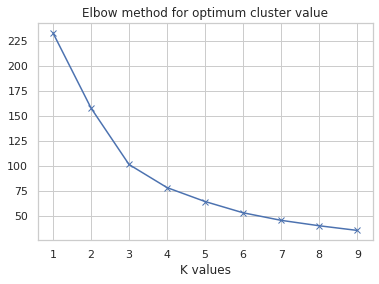

In [38]:
# To derive more coordinate related features, coordinates will be clustered. First optimum cluster value is found by elbow method.
kmeans = KMeans()
ssd = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(df[["lat_scaled", "long_scaled"]])
    ssd.append(kmeans.inertia_)

plt.plot(K, ssd, "bx-")
plt.xlabel("K values")
plt.title("Elbow method for optimum cluster value")
plt.show()


In [39]:
# The sharpest incline is at 3, so it is chosen as the cluster value.

kmeans = KMeans(n_clusters=3)
k_fit = kmeans.fit(df[["lat_scaled", "long_scaled"]].values)


In [40]:
sets = kmeans.labels_


In [41]:
df["cluster_no"] = sets

In [42]:
df.loc[df["cluster_no"] == 0, "cluster_no"] = "cl_zero"
df.loc[df["cluster_no"] == 1, "cluster_no"] = "cl_one"
df.loc[df["cluster_no"] == 2, "cluster_no"] = "cl_two"

In [43]:
df.head()

,Age,Gender,Marital Status,Occupation,Monthly Income,Educational Qualifications,Family size,latitude,longitude,Output,Feedback,Family size_cat,Income per capita,Age_income,Age_monthlyi,Edu_inc,Age_fam,Age_occ,Edu_occ,Edu_occ_inc,Edu_fam,Occ_fam,Income_cat,MaritalOcc,MaritalInc,Feedgend,Age_cat,Young_Pos,Feedage,FeedInc,FeedEdu,FeedMon,FeedOcc,lat_avg,lon_avg,lat_std,lon_std,lat_overlong,lat_scaled,long_scaled,lat_long,cluster_no
0,20,0,0,0,0,3,4,12.977,77.599,1,1,Crowded,0.000,0.000,0,0.000,80,0,0,0.000,0.750,0.000,0,SinStu,Sinvlow,Posf,0,1,Posavy,Posvl,Pospg,Posivl,Posstu,12.972,77.600,0.004,0.001,0.167,0.470,0.420,0.198,cl_zero
1,24,0,0,0,1,2,3,12.977,77.577,1,1,Medium,0.333,8.000,24,0.667,72,0,0,0.000,0.667,0.000,0,SinStu,Sinvlow,Posf,1,0,Posay,Posvl,Posg,Posil,Posstu,12.972,77.600,0.005,0.023,0.167,0.472,0.340,0.160,cl_zero
2,22,1,0,0,1,3,3,12.955,77.659,1,0,Medium,0.333,7.333,22,1.000,66,0,0,0.000,1.000,0.000,0,SinStu,Sinvlow,Negm,0,0,Negavy,Negvl,Negpg,Negil,Negstu,12.972,77.600,0.017,0.059,0.167,0.380,0.639,0.243,cl_two
3,22,0,0,0,0,2,6,12.947,77.562,1,1,Crowded,0.000,0.000,0,0.000,132,0,0,0.000,0.333,0.000,0,SinStu,Sinvlow,Posf,0,1,Posavy,Posvl,Posg,Posivl,Posstu,12.972,77.600,0.025,0.039,0.167,0.347,0.282,0.098,cl_one
4,22,1,0,0,1,3,4,12.985,77.553,1,1,Crowded,0.250,5.500,22,0.750,88,0,0,0.000,0.750,0.000,0,SinStu,Sinvlow,Posm,0,1,Posavy,Posvl,Pospg,Posil,Posstu,12.972,77.600,0.013,0.047,0.167,0.506,0.252,0.128,cl_zero


In [44]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 3388
Variables: 42
cat_cols: 27
num_cols: 10
cat_but_car: 5
num_but_cat: 10


In [45]:
num_cols = [col for col in num_cols if col not in ["Pin code", "latitude", "longitude"] ]

In [46]:
for col in num_cols:
    print(col, check_outlier(df, col))

Age False
Age_fam False
lat_std False
lon_std False
lat_overlong False
lat_scaled False
long_scaled False
lat_long False


In [47]:
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [48]:
for col in cat_cols:
    cat_summary(df, col)

   Occupation  Ratio
0        1863 54.988
2        1048 30.933
1         477 14.079
##########################################
   Monthly Income  Ratio
0            1626 47.993
3             611 18.034
4             554 16.352
2             384 11.334
1             213  6.287
##########################################
   Educational Qualifications  Ratio
2                        1560 46.045
3                        1519 44.835
4                         185  5.460
1                         108  3.188
0                          16  0.472
##########################################
         Family size_cat  Ratio
Medium              1949 57.527
Crowded             1252 36.954
Single               187  5.519
##########################################
       Income per capita  Ratio
0.000               1626 47.993
1.000                415 12.249
1.333                178  5.254
1.500                165  4.870
0.667                160  4.723
0.500                156  4.604
2.000               

In [49]:
for col in num_cols:
    num_summary(df, col)

count   3388.000
mean      24.682
std        2.973
min       18.000
5%        21.000
10%       22.000
20%       22.000
30%       23.000
40%       23.000
50%       24.000
60%       25.000
70%       26.000
80%       27.000
90%       29.000
95%       31.000
99%       32.000
max       33.000
Name: Age, dtype: float64
count   3388.000
mean      81.108
std       34.514
min       20.000
5%        30.000
10%       44.000
20%       50.000
30%       60.000
40%       69.000
50%       75.000
60%       84.000
70%       96.000
80%      112.000
90%      130.000
95%      145.000
99%      168.780
max      192.000
Name: Age_fam, dtype: float64
count   3388.000
mean       0.034
std        0.028
min        0.000
5%         0.003
10%        0.005
20%        0.006
30%        0.013
40%        0.017
50%        0.029
60%        0.038
70%        0.044
80%        0.057
90%        0.077
95%        0.090
99%        0.107
max        0.130
Name: lat_std, dtype: float64
count   3388.000
mean       0.039
std        0.

In [50]:
for col in cat_cols:
    target_summary_with_cat(df, "Output", col)

            TARGET_MEAN
Occupation             
0                 0.786
1                 0.776
2                 0.735


                TARGET_MEAN
Monthly Income             
0                     0.775
1                     0.775
2                     0.799
3                     0.732
4                     0.769


                            TARGET_MEAN
Educational Qualifications             
0                                 0.875
1                                 0.787
2                                 0.762
3                                 0.774
4                                 0.768


                 TARGET_MEAN
Family size_cat             
Crowded                0.776
Medium                 0.771
Single                 0.706


                   TARGET_MEAN
Income per capita             
0.000                    0.775
0.167                    0.647
0.200                    0.808
0.250                    0.677
0.333                    0.825
0.400                    0.818
0.5

In [51]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

df = one_hot_encoder(df, ohe_cols)

## Modelling

In [52]:
y = df["Output"]
X = df.drop(["Output", "lat_scaled", "long_scaled", "latitude", "longitude"], axis=1)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

In [54]:
rf_model = RandomForestClassifier(random_state=17)

rf_random_params = {"max_depth": np.random.randint(5, 50, 10),
                    "max_features": [3, 5, 7, "auto", "sqrt"],
                    "min_samples_split": np.random.randint(2, 50, 20),
                    "n_estimators": [int(x) for x in np.linspace(start=200, stop=1500, num=10)]}


rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_random_params, n_iter=100, cv=3, verbose=False, n_jobs=-1)

rf_random.fit(X_train, y_train)

rf_random.best_params_



{'n_estimators': 1355,
 'min_samples_split': 4,
 'max_features': 'auto',
 'max_depth': 8}

In [56]:
rf_model = RandomForestClassifier()

rf_params = {"max_depth": [5, 10, 20, None],
             "max_features": [3, 5, 9, "auto"],
             "min_samples_split": [4, 14, 25],
             "n_estimators": [1300, 1350, 1400]}

rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=False).fit(X_train, y_train)

rf_final = rf_model.set_params(**rf_best_grid.best_params_).fit(X_train, y_train)

cv_results = cross_validate(rf_final, X_train, y_train, cv=5, scoring=["f1"])

In [57]:
rf_best_grid.best_params_

{'max_depth': 10,
 'max_features': 3,
 'min_samples_split': 4,
 'n_estimators': 1350}

In [58]:
#The data is imbalanced so f1 score is used as the performance metric.
cv_results["test_f1"].mean()

0.8683781027423848

In [59]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(16, 16))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

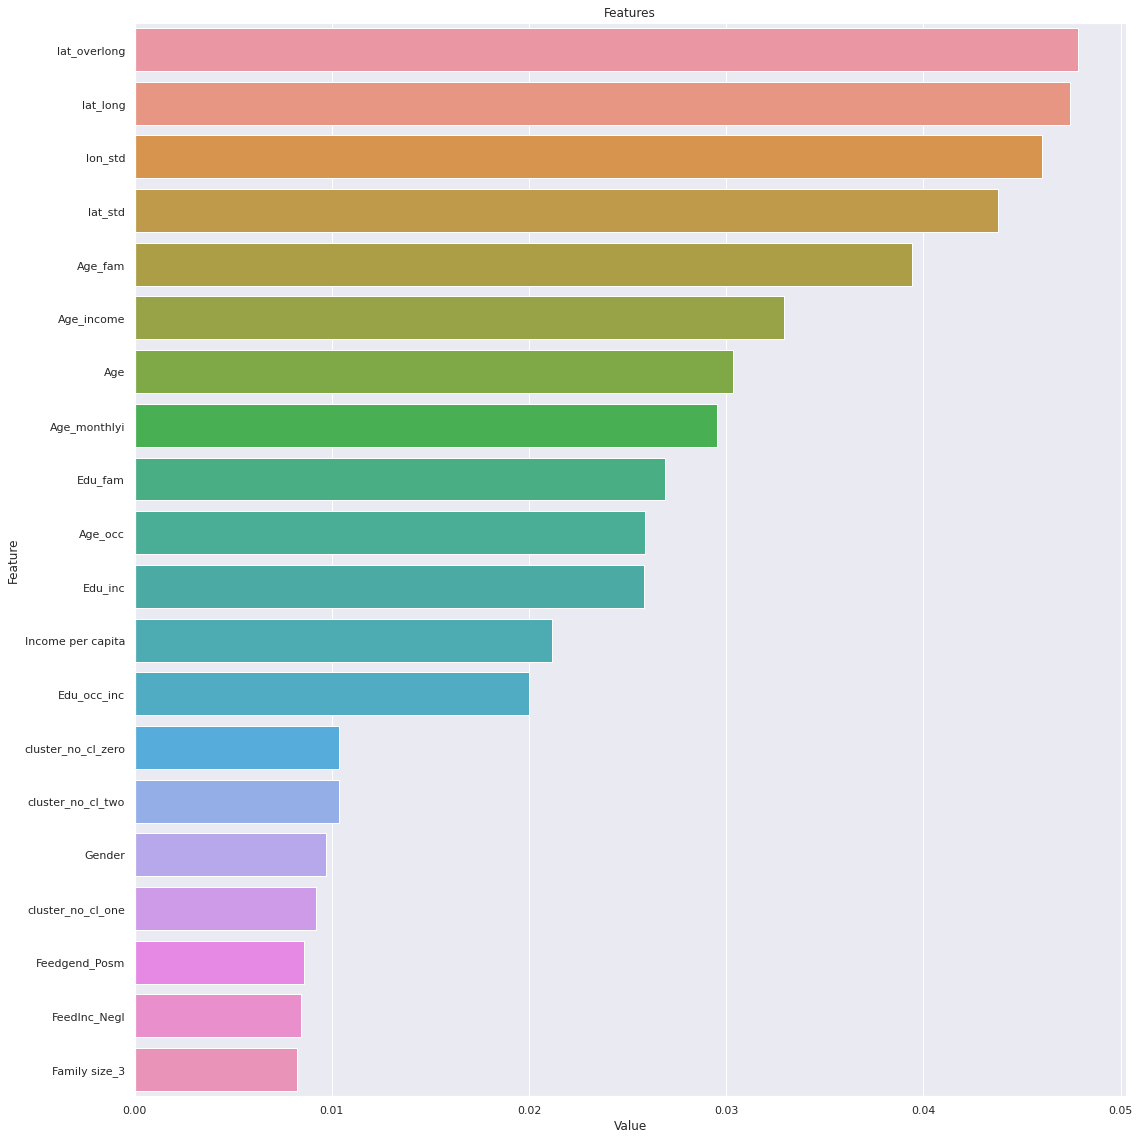

In [60]:
# As can be seen, the majority of the most important features of the model are the derived features.
plot_importance(rf_final, X, 20)

In [61]:
rf_pred = rf_final.predict(X_test)
confusion_matrix(y_test, rf_pred)

array([[  3, 143],
       [  0, 532]])

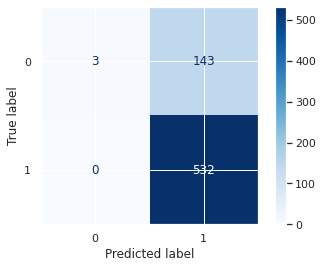

In [62]:
# It can be seen that 532 of the 532 positives and 3 of 146 negatives are predicted correctly. 
plot_confusion_matrix(rf_final, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [63]:
# The f1 score which is the harmonic mean of the precision and recall scores is 0.88.
f1_score(y_test, rf_pred)

0.8815244407622205